In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
df = pd.read_csv('bitcoin.csv')

In [4]:
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [5]:
df.info

<bound method DataFrame.info of             Date          Open          High           Low         Close  \
0     2014-09-17    465.864014    468.174011    452.421997    457.334015   
1     2014-09-18    456.859985    456.859985    413.104004    424.440002   
2     2014-09-19    424.102997    427.834991    384.532013    394.795990   
3     2014-09-20    394.673004    423.295990    389.882996    408.903992   
4     2014-09-21    408.084991    412.425995    393.181000    398.821014   
...          ...           ...           ...           ...           ...   
2708  2022-02-15  42586.464844  44667.218750  42491.035156  44575.203125   
2709  2022-02-16  44578.277344  44578.277344  43456.691406  43961.859375   
2710  2022-02-17  43937.070313  44132.972656  40249.371094  40538.011719   
2711  2022-02-18  40552.132813  40929.152344  39637.617188  40030.976563   
2712  2022-02-19  40022.132813  40246.027344  40010.867188  40126.429688   

         Adj Close       Volume  
0       457.334015   

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
#clean cloumn name
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
)


In [8]:
# data preprocessing
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df.set_index('date', inplace=True)

In [9]:
#select price coulmn
if 'close' in df.columns:
    price_col = 'close'
elif 'adj_close' in df.columns:
    price_col = 'adj_close'
else:
    raise ValueError("No Close price column found")

print("Price column used:", price_col)

Price column used: close


### Create Target Variable (Trend)
1 → Price goes UP

0 → Price goes DOWN

In [10]:
df['price_change'] = df[price_col].diff()
df['trend'] = np.where(df['price_change'] > 0, 1, 0)

In [11]:
#create lag feature
df['lag_1'] = df[price_col].shift(1)
df['lag_2'] = df[price_col].shift(2)
df['lag_3'] = df[price_col].shift(3)


In [12]:
# Moving averages
df['ma_7'] = df[price_col].rolling(window=7).mean()
df['ma_21'] = df[price_col].rolling(window=21).mean()

# Volatility
df['volatility'] = df[price_col].rolling(window=7).std()


In [13]:
# drop missing value
df.dropna(inplace=True)

In [14]:
#define feature x and target y
X = df.drop(columns=['trend', 'price_change'])
y = df['trend']

# Keep numeric columns only
X = X.select_dtypes(include=[np.number])


### train-test split

In [15]:
split_index = int(len(df) * 0.8)

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]

### feature scaling

In [16]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### train machine learning model

In [17]:
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42
)

model.fit(X_train_scaled, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [18]:
#make predict
y_pred = model.predict(X_test_scaled)

In [19]:
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.4935064935064935

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.94      0.63       249
           1       0.68      0.11      0.19       290

    accuracy                           0.49       539
   macro avg       0.58      0.53      0.41       539
weighted avg       0.59      0.49      0.39       539


Confusion Matrix:
[[234  15]
 [258  32]]


### feature importence

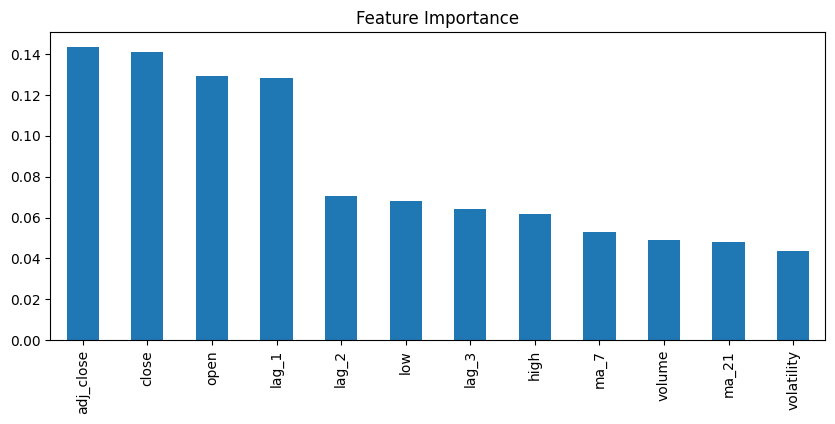

In [20]:
importance = pd.Series(
    model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

importance.plot(kind='bar', figsize=(10,4), title='Feature Importance')
plt.show()


### Predic next Day Trend

In [21]:
last_row = X.iloc[-1:].values
last_row_scaled = scaler.transform(last_row)

prediction = model.predict(last_row_scaled)

if prediction[0] == 1:
    print("📈 Predicted Trend: UP")
else:
    print("📉 Predicted Trend: DOWN")

📉 Predicted Trend: DOWN
